In [ ]:
import yfinance as yf
import pandas as pd

nvda_stock = yf.download('NVDA', start='2019-11-29', end='2024-03-04')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
full_date_range = pd.date_range(start=nvda_stock.index.min(), end=nvda_stock.index.max())
closed_market_days = full_date_range.difference(nvda_stock.index)

In [ ]:
df_bert = pd.read_csv('nvidia_articles_bert.csv')

In [ ]:
df_bert.head()

,title,published,source,link,published_date,cleaned_title,sentiment,sentiment_score
0,The NVIDIA Shield TV Pro (2019) is my favorite...,2020-01-01 08:00:00,Android Central,https://news.google.com/rss/articles/CBMiUmh0d...,2020-01-01 08:00:00,nvidia shield tv pro 2019 favorite purchase year,POSITIVE,0.977575
1,Exploring CPU & GPU Rendering Performance With...,2020-01-01 08:00:00,Techgage,https://news.google.com/rss/articles/CBMiVGh0d...,2020-01-01 08:00:00,exploring cpu gpu rendering performance keyshot 9,POSITIVE,0.995750
2,AMD Radeon RX 5600M 6 GB Mobility GPU Benchmar...,2020-01-02 08:00:00,Wccftech,https://news.google.com/rss/articles/CBMiUmh0d...,2020-01-02 08:00:00,amd radeon rx 5600m 6 gb mobility gpu benchmar...,NEGATIVE,0.961462
3,"Top tech of 2020 – Intel Xe to AMD Zen 3, Nvid...",2020-01-02 08:00:00,PCGamesN,https://news.google.com/rss/articles/CBMiM2h0d...,2020-01-02 08:00:00,top tech 2020 – intel xe amd zen 3 nvidia ampe...,POSITIVE,0.987215
4,NVIDIA is actually working on two new Shield T...,2020-01-02 08:00:00,Android Central,https://news.google.com/rss/articles/CBMiUGh0d...,2020-01-02 08:00:00,nvidia actually working two new shield tv devices,NEGATIVE,0.989989


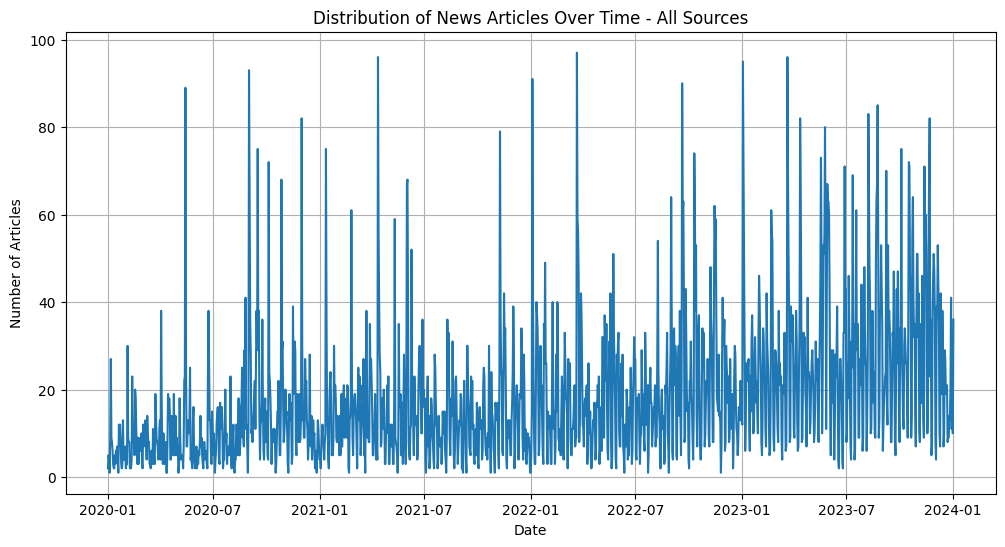

Missing Dates:
DatetimeIndex(['2020-04-26', '2020-05-08', '2021-02-14', '2021-03-06',
               '2021-12-26'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
import matplotlib.pyplot as plt

df_bert['published'] = pd.to_datetime(df_bert['published'], format='%a, %d %b %Y %H:%M:%S GMT')

articles_per_day = df_bert['published'].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 6))
articles_per_day.plot(kind='line')
plt.title('Distribution of News Articles Over Time - All Sources')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

# Checking for Missing Dates
full_date_range = pd.date_range(start=articles_per_day.index.min(), end=articles_per_day.index.max())
missing_dates = full_date_range.difference(pd.to_datetime(articles_per_day.index))

print("Missing Dates:")
print(missing_dates)


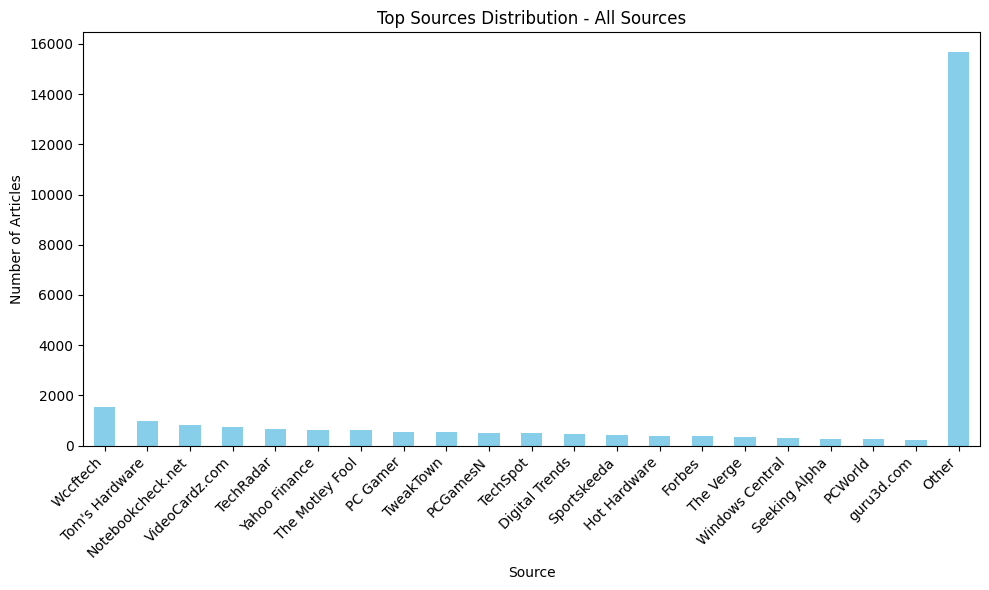

In [ ]:
source_counts = df_bert['source'].value_counts()
top_n = 20
top_sources = source_counts.nlargest(top_n)
top_sources['Other'] = source_counts[top_n:].sum()

# Plotting the top N sources with 'Other' category
plt.figure(figsize=(10, 6))
top_sources.plot(kind='bar', color='skyblue')
plt.title('Top Sources Distribution - All Sources')
plt.xlabel('Source')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



BERT - All Sources

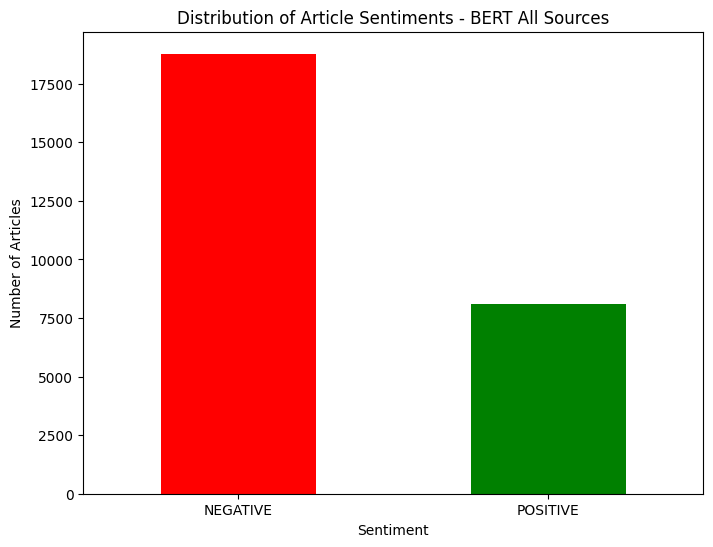

In [ ]:
sentiment_counts = df_bert['sentiment'].value_counts()

# Plotting the sentiment counts
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'green', 'gray'])
plt.title('Distribution of Article Sentiments - BERT All Sources')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.show()

Açık günde yayınlanan için: O günün Close - Bir önceki açık günün Close

Kapalı günde yayınlanan için: Bir sonraki açık günün Close - Bir önceki açık günün Close

In [ ]:
from scipy.stats import chi2_contingency

df_bert['numeric_score'] = df_bert.apply(lambda row: row['sentiment_score'] if row['sentiment'] == 'POSITIVE' else -row['sentiment_score'], axis=1)

def classify_publication_time(row):
    local_publish_date = pd.Timestamp(row['published'].date())
    if local_publish_date in closed_market_days:
        return 'Closed Day'
    else:
        return 'Open Day'

df_bert['market_condition'] = df_bert.apply(classify_publication_time, axis=1)

def find_next_open_day(current_date):
    next_day = pd.Timestamp(current_date) + pd.DateOffset(days=1)
    while next_day in closed_market_days:
        next_day += pd.DateOffset(days=1)
    return next_day

def find_last_open_day(current_date):
    prev_day = pd.Timestamp(current_date) - pd.DateOffset(days=1)  # current_date'i Timestamp'a çevir
    while prev_day in closed_market_days:
        prev_day -= pd.DateOffset(days=1)
    return prev_day

def calculate_impact(row):
    local_publish_date = pd.Timestamp(row['published'].date())
    if row['market_condition'] == 'Open Day':
        prev_open_day = find_last_open_day(local_publish_date)
        impact_value = nvda_stock.loc[local_publish_date, 'Close'] - nvda_stock.loc[prev_open_day, 'Close']
        impact_group = f'{local_publish_date} Close - {prev_open_day} Close'
    elif row['market_condition'] == 'Closed Day':
        next_open_day = find_next_open_day(local_publish_date)
        last_close_day = find_last_open_day(local_publish_date)
        impact_value = nvda_stock.loc[next_open_day, 'Close'] - nvda_stock.loc[last_close_day, 'Close']
        impact_group = f'{next_open_day} Close - {last_close_day} Close'
    return impact_value, impact_group

results = df_bert.apply(calculate_impact, axis=1, result_type='expand')
df_bert['impact'] = results[0]
df_bert['impact_group'] = results[1]

grouped_data = df_bert.groupby('impact_group').agg({
    'numeric_score': 'mean',
    'impact': 'mean'
}).reset_index()

# Continous vs Continous
# Lineer Correlation
correlation1 = grouped_data['numeric_score'].corr(grouped_data['impact'])
print("Bütün sourcelar ile BERT")
print("Bugün yayınlanan için bugünün close'u - bir önceki günün close'u")
print("Korelasyon Katsayısı:", correlation1)

def impact_type(row):
  if row['impact'] > 0:
    return 'Positive'
  elif row['impact'] == 0:
    return 'Neutral'
  else:
    return 'Negative'

def sentiment_type(row):
  if row['numeric_score'] > 0:
    return 'POSITIVE'
  elif row['numeric_score'] == 0:
    return 'NEUTRAL'
  else:
    return 'NEGATIVE'

grouped_data['numeric_score_type'] = grouped_data.apply(sentiment_type, axis=1)
grouped_data['impact_type'] = grouped_data.apply(impact_type, axis=1)

# Continous vs Categorical
# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('numeric_score ~ C(impact_type)', data=grouped_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print("ANOVA:", anova_result)

# Categorical vs Categorical
# Chi-Square Test
contingency_table1 = pd.crosstab(grouped_data['numeric_score_type'], grouped_data['impact_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table1)
print("Chi-square test:", chi2)
print("p-value:", p)


Bütün sourcelar ile BERT
Bugün yayınlanan için bugünün close'u - bir önceki günün close'u
Korelasyon Katsayısı: 0.059557909310346394
ANOVA:                    sum_sq      df         F    PR(>F)
C(impact_type)   0.215554     2.0  1.739209  0.176189
Residual        62.154847  1003.0       NaN       NaN
Chi-square test: 0.28530726197829515
p-value: 0.8670543376438774


The statistical tests suggest that sentiment scores do not vary significantly with stock price changes and that sentiment types are independent of stock movement types.

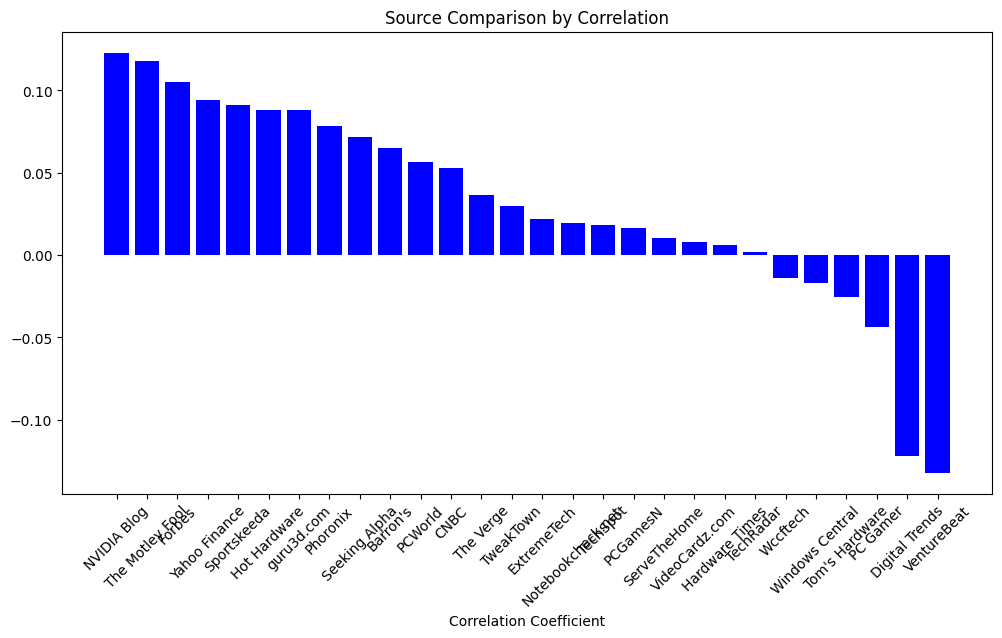

In [ ]:
source_correlations = []
for source in df_bert['source'].unique():
    data = df_bert[df_bert['source'] == source]
    if data.shape[0] > 200:
      grouped_data = data.groupby('impact_group').agg({
        'numeric_score': 'mean',
        'impact': 'mean'
      }).reset_index()
      correlation = grouped_data['numeric_score'].corr(grouped_data['impact'])
      source_correlations.append((source, correlation, data.shape[0]))

source_correlations_df = pd.DataFrame(source_correlations, columns=['Source', 'Correlation', 'Count'])
source_correlations_df = source_correlations_df.sort_values(by='Correlation', ascending=False)
# Korelasyon katsayılarını çiz
plt.figure(figsize=(12, 6))
plt.bar(source_correlations_df['Source'], source_correlations_df['Correlation'], color='blue')
plt.xlabel('Source')
plt.xlabel('Correlation Coefficient')
plt.title('Source Comparison by Correlation')
plt.xticks(rotation=45)
plt.show()

In [ ]:
source_correlations_df

,Source,Correlation,Count
7,NVIDIA Blog,0.122938,230
13,The Motley Fool,0.117750,614
12,Forbes,0.104807,377
15,Yahoo Finance,0.094313,625
26,Sportskeeda,0.091240,424
21,Hot Hardware,0.087970,383
20,guru3d.com,0.087820,243
18,Phoronix,0.078392,219
24,Seeking Alpha,0.071586,270
27,Barron's,0.064788,225


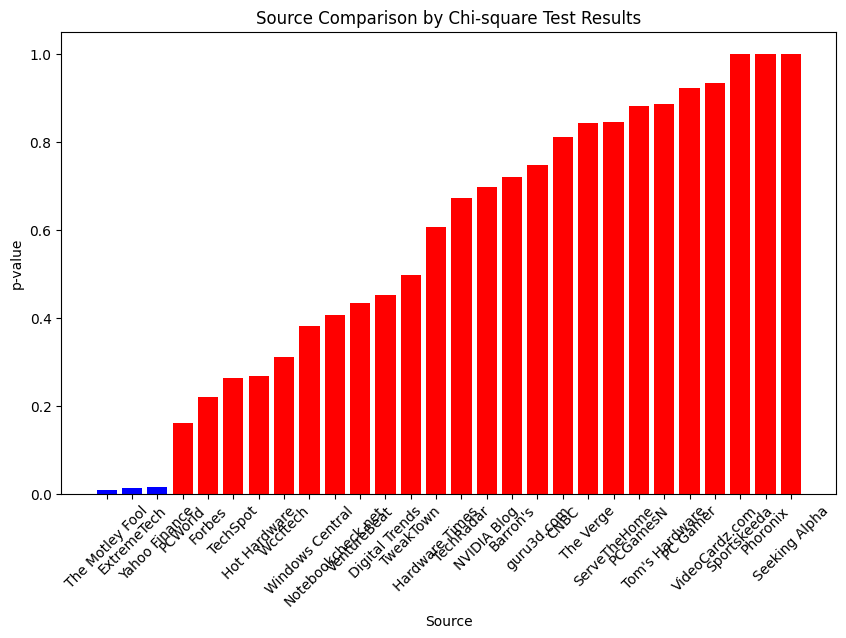

In [ ]:
# Her kaynak için Chi-kare testi
chi_square_results = []
for source in df_bert['source'].unique():
    data = df_bert[df_bert['source'] == source]
    if data.shape[0] > 200:
      grouped_data = data.groupby('impact_group').agg({
        'numeric_score': 'mean',
        'impact': 'mean'
      }).reset_index()
      grouped_data['numeric_score_type'] = grouped_data.apply(sentiment_type, axis=1)
      grouped_data['impact_type'] = grouped_data.apply(impact_type, axis=1)
      contingency_table = pd.crosstab(grouped_data['numeric_score_type'], grouped_data['impact_type'])
      chi2, p, dof, expected = chi2_contingency(contingency_table)
      chi_square_results.append((source,data.shape[0],chi2, p))

chi_square_results_df = pd.DataFrame(chi_square_results, columns=['Source','Count','Chi-square', 'p-value'])
chi_square_results_df = chi_square_results_df.sort_values(by='p-value', ascending=True)

# Chi-kare sonuçlarını çiz
plt.figure(figsize=(10, 6))
for i, row in chi_square_results_df.iterrows():
    color = 'blue' if row['p-value'] < 0.05 else 'red'
    plt.bar(row['Source'], row['p-value'], color=color)

plt.xlabel('Source')
plt.ylabel('p-value')
plt.title('Source Comparison by Chi-square Test Results')
plt.xticks(rotation=45)  # Etiketleri 45 derece eğik yap
plt.show()



In [ ]:
chi_square_results_df

,Source,Count,Chi-square,p-value
13,The Motley Fool,614,9.460545,0.008824
5,ExtremeTech,202,8.707046,0.012861
15,Yahoo Finance,625,8.421491,0.014835
8,PCWorld,268,3.669330,0.159667
12,Forbes,377,1.505888,0.219768
3,TechSpot,519,2.671597,0.262948
21,Hot Hardware,383,2.631496,0.268274
0,Wccftech,1523,2.345575,0.309503
22,Windows Central,293,1.933584,0.380301
17,Notebookcheck.net,827,0.689163,0.406449


20 trusted source limitation

In [ ]:
df_bert_source_limited = df_bert
news_outlets = [
    "Yahoo Finance", "The Motley Fool", "Forbes", "Seeking Alpha"," Barron's","CNBC",
    "Reuters", "MarketWatch", "Bloomberg", "Investor's Business Daily", "TheStreet", "The Wall Street Journal",
    "Markets Insider", "Business Insider", "Financial Times", "Investopedia", "Nasdaq", "Fortune", "The Economic Times", "Fox Business"
]

df_bert_source_limited = df_bert[df_bert['source'].isin(news_outlets)].copy()
df_bert_source_limited.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3436 entries, 55 to 26864
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             3436 non-null   object        
 1   published         3436 non-null   datetime64[ns]
 2   source            3436 non-null   object        
 3   link              3436 non-null   object        
 4   published_date    3436 non-null   object        
 5   cleaned_title     3436 non-null   object        
 6   sentiment         3436 non-null   object        
 7   sentiment_score   3436 non-null   float64       
 8   numeric_score     3436 non-null   float64       
 9   market_condition  3436 non-null   object        
 10  impact            3436 non-null   float64       
 11  impact_group      3436 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 349.0+ KB


In [ ]:
from scipy.stats import chi2_contingency

df_bert_source_limited['numeric_score'] = df_bert_source_limited.apply(lambda row: row['sentiment_score'] if row['sentiment'] == 'POSITIVE' else -row['sentiment_score'], axis=1)

def classify_publication_time(row):
    local_publish_date = pd.Timestamp(row['published'].date())
    if local_publish_date in closed_market_days:
        return 'Closed Day'
    else:
        return 'Open Day'

df_bert_source_limited['market_condition'] = df_bert_source_limited.apply(classify_publication_time, axis=1)

def find_next_open_day(current_date):
    next_day = pd.Timestamp(current_date) + pd.DateOffset(days=1)
    while next_day in closed_market_days:
        next_day += pd.DateOffset(days=1)
    return next_day

def find_last_open_day(current_date):
    prev_day = pd.Timestamp(current_date) - pd.DateOffset(days=1)  # current_date'i Timestamp'a çevir
    while prev_day in closed_market_days:
        prev_day -= pd.DateOffset(days=1)
    return prev_day

def calculate_impact(row):
    local_publish_date = pd.Timestamp(row['published'].date())
    if row['market_condition'] == 'Open Day':
        prev_open_day = find_last_open_day(local_publish_date)
        impact_value = nvda_stock.loc[local_publish_date, 'Close'] - nvda_stock.loc[prev_open_day, 'Close']
        impact_group = f'{local_publish_date} Close - {prev_open_day} Close'
    elif row['market_condition'] == 'Closed Day':
        next_open_day = find_next_open_day(local_publish_date)
        last_close_day = find_last_open_day(local_publish_date)
        impact_value = nvda_stock.loc[next_open_day, 'Close'] - nvda_stock.loc[last_close_day, 'Close']
        impact_group = f'{next_open_day} Close - {last_close_day} Close'
    return impact_value, impact_group

results = df_bert_source_limited.apply(calculate_impact, axis=1, result_type='expand')
df_bert_source_limited['impact'] = results[0]
df_bert_source_limited['impact_group'] = results[1]

grouped_data = df_bert_source_limited.groupby('impact_group').agg({
    'numeric_score': 'mean',
    'impact': 'mean'
}).reset_index()

# Continous vs Continous
# Lineer Correlation
correlation1 = grouped_data['numeric_score'].corr(grouped_data['impact'])
print("20 source ile BERT")
print("Bugün yayınlanan için bugünün close'u - bir önceki günün close'u")
print("Korelasyon Katsayısı:", correlation1)

def impact_type(row):
  if row['impact'] > 0:
    return 'Positive'
  elif row['impact'] == 0:
    return 'Neutral'
  else:
    return 'Negative'

def sentiment_type(row):
  if row['numeric_score'] > 0:
    return 'POSITIVE'
  elif row['numeric_score'] == 0:
    return 'NEUTRAL'
  else:
    return 'NEGATIVE'

grouped_data['numeric_score_type'] = grouped_data.apply(sentiment_type, axis=1)
grouped_data['impact_type'] = grouped_data.apply(impact_type, axis=1)

# Continous vs Categorical
# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('numeric_score ~ C(impact_type)', data=grouped_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print("ANOVA:", anova_result)

# Categorical vs Categorical
# Chi-Square Test
contingency_table1 = pd.crosstab(grouped_data['numeric_score_type'], grouped_data['impact_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table1)
print("Chi-square test:", chi2)
print("p-value:", p)


20 source ile BERT
Bugün yayınlanan için bugünün close'u - bir önceki günün close'u
Korelasyon Katsayısı: 0.09120974995317989
ANOVA:                     sum_sq     df         F    PR(>F)
C(impact_type)    4.168638    2.0  5.057296  0.006591
Residual        295.917228  718.0       NaN       NaN
Chi-square test: 11.766514593461821
p-value: 0.0027856966403227938


In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Önceki Chi-square testinizden elde edilen değerleri kullanalım
dof = min((contingency_table1.shape[0] - 1), (contingency_table1.shape[1] - 1))

# Cramer's V katsayısını hesaplama
n = contingency_table1.sum().sum()  # Toplam gözlem sayısı
cramer_v = np.sqrt(chi2 / (n * dof))

print("Cramer's V Katsayısı:", cramer_v)

# Kondisyonel olasılık hesaplamaları için
conditional_probabilities = contingency_table1.div(contingency_table1.sum(axis=1), axis=0)
print("\nKondisyonel Olasılıklar:\n", conditional_probabilities)


Cramer's V Katsayısı: 0.1277486403404107

Kondisyonel Olasılıklar:
 impact_type         Negative   Neutral  Positive
numeric_score_type                              
NEGATIVE            0.473310  0.000000  0.526690
POSITIVE            0.371069  0.012579  0.616352


while the correlation between sentiment and stock price movements is weak, there is statistically significant evidence from the ANOVA and Chi-square tests indicating that different types of sentiment are associated with different types of stock price changes. This suggests that the sentiment expressed in news headlines, particularly from these 20 sources, does have an impact on stock price movements

FinBERT

In [ ]:
df_finbert = pd.read_csv('nvidia_articles_finbert.csv')

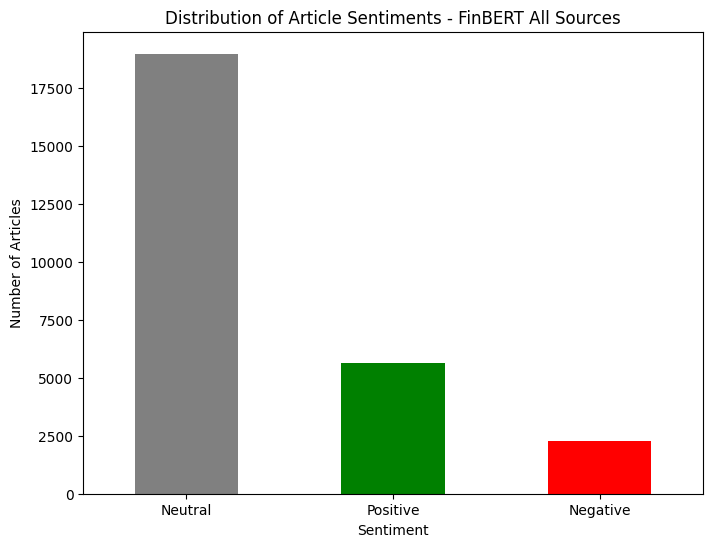

In [ ]:
sentiment_counts = df_finbert['sentiment'].value_counts()

# Plotting the sentiment counts
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['gray', 'green', 'red'])
plt.title('Distribution of Article Sentiments - FinBERT All Sources')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

df_finbert['published'] = pd.to_datetime(df_finbert['published'], format='%Y-%m-%d %H:%M:%S')

def numeric_score(row):
  if row['sentiment'] == 'Positive':
    return row['sentiment_score']
  elif row['sentiment'] == 'Negative':
    return -row['sentiment_score']
  else:
    return 0
df_finbert['numeric_score'] = df_finbert.apply(numeric_score, axis=1)

def classify_publication_time(row):
    local_publish_date = pd.Timestamp(row['published'].date())
    if local_publish_date in closed_market_days:
        return 'Closed Day'
    else:
        return 'Open Day'

df_finbert['market_condition'] = df_finbert.apply(classify_publication_time, axis=1)

def find_next_open_day(current_date):
    next_day = pd.Timestamp(current_date) + pd.DateOffset(days=1)
    while next_day in closed_market_days:
        next_day += pd.DateOffset(days=1)
    return next_day

def find_last_open_day(current_date):
    prev_day = pd.Timestamp(current_date) - pd.DateOffset(days=1)  # current_date'i Timestamp'a çevir
    while prev_day in closed_market_days:
        prev_day -= pd.DateOffset(days=1)
    return prev_day

def calculate_impact(row):
    local_publish_date = pd.Timestamp(row['published'].date())
    if row['market_condition'] == 'Open Day':
        prev_open_day = find_last_open_day(local_publish_date)
        impact_value = nvda_stock.loc[local_publish_date, 'Close'] - nvda_stock.loc[prev_open_day, 'Close']
        impact_group = f'{local_publish_date} Close - {prev_open_day} Close'
    elif row['market_condition'] == 'Closed Day':
        next_open_day = find_next_open_day(local_publish_date)
        last_close_day = find_last_open_day(local_publish_date)
        impact_value = nvda_stock.loc[next_open_day, 'Close'] - nvda_stock.loc[last_close_day, 'Close']
        impact_group = f'{next_open_day} Close - {last_close_day} Close'
    return impact_value, impact_group

results = df_finbert.apply(calculate_impact, axis=1, result_type='expand')
df_finbert['impact'] = results[0]
df_finbert['impact_group'] = results[1]

grouped_data = df_finbert.groupby('impact_group').agg({
    'numeric_score': 'mean',
    'impact': 'mean'
}).reset_index()

# Continous vs Continous
# Lineer Correlation
correlation1 = grouped_data['numeric_score'].corr(grouped_data['impact'])
print("Bütün sourcelar ile FinBERT")
print("Bugün yayınlanan için bugünün close'u - bir önceki günün close'u")
print("Korelasyon Katsayısı:", correlation1)

def impact_type(row):
  if row['impact'] > 0:
    return 'Positive'
  elif row['impact'] == 0:
    return 'Neutral'
  else:
    return 'Negative'

def sentiment_type(row):
  if row['numeric_score'] > 0:
    return 'POSITIVE'
  elif row['numeric_score'] == 0:
    return 'NEUTRAL'
  else:
    return 'NEGATIVE'

grouped_data['numeric_score_type'] = grouped_data.apply(sentiment_type, axis=1)
grouped_data['impact_type'] = grouped_data.apply(impact_type, axis=1)

# Continous vs Categorical
# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('numeric_score ~ C(impact_type)', data=grouped_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print("ANOVA:", anova_result)

# Categorical vs Categorical
# Chi-Square Test
contingency_table1 = pd.crosstab(grouped_data['numeric_score_type'], grouped_data['impact_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table1)
print("Chi-square test:", chi2)
print("p-value:", p)


Bütün sourcelar ile FinBERT
Bugün yayınlanan için bugünün close'u - bir önceki günün close'u
Korelasyon Katsayısı: 0.08984362656974239
ANOVA:                    sum_sq      df         F    PR(>F)
C(impact_type)   0.147695     2.0  3.752062  0.023799
Residual        19.740936  1003.0       NaN       NaN
Chi-square test: 13.254436881203485
p-value: 0.010097219224058781


In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Önceki Chi-square testinizden elde edilen değerleri kullanalım
dof = min((contingency_table1.shape[0] - 1), (contingency_table1.shape[1] - 1))

# Cramer's V katsayısını hesaplama
n = contingency_table1.sum().sum()  # Toplam gözlem sayısı
cramer_v = np.sqrt(chi2 / (n * dof))

print("Cramer's V Katsayısı:", cramer_v)

# Kondisyonel olasılık hesaplamaları için
conditional_probabilities = contingency_table1.div(contingency_table1.sum(axis=1), axis=0)
print("\nKondisyonel Olasılıklar:\n", conditional_probabilities)


Cramer's V Katsayısı: 0.08116459996131602

Kondisyonel Olasılıklar:
 impact_type         Negative   Neutral  Positive
numeric_score_type                              
NEGATIVE            0.582278  0.000000  0.417722
NEUTRAL             0.352941  0.000000  0.647059
POSITIVE            0.436118  0.002457  0.561425


The statistical analysis using FinBERT demonstrates that while there is a very weak direct linear correlation between sentiment scores and stock price movements, there is significant statistical evidence from the ANOVA and Chi-square tests that different sentiment types are associated with different stock price movements. These findings imply that although sentiment analysis alone might not strongly predict day-to-day stock price changes, the type of sentiment expressed in news headlines can be significantly related to the direction of stock price movements. This suggests the utility of sentiment analysis as part of a broader set of tools for predicting or understanding stock price dynamics, particularly when differentiating by the type of sentiment expressed.

In [ ]:
def find_next_open_day_(current_date, delay):
    next_day = pd.Timestamp(current_date) + pd.DateOffset(days=delay)
    while next_day in closed_market_days:
        next_day += pd.DateOffset(days=1)
    return next_day

def find_last_open_day_(current_date):
    prev_day = pd.Timestamp(current_date) - pd.DateOffset(days=1)  # current_date'i Timestamp'a çevir
    while prev_day in closed_market_days:
        prev_day -= pd.DateOffset(days=1)
    return prev_day

def calculate_impact_(row, delay):
    local_publish_date = pd.Timestamp(row['published'].date())
    if row['market_condition'] == 'Open Day':
        next_open_day = find_next_open_day_(local_publish_date, delay)
        impact_value = nvda_stock.loc[next_open_day, 'Close'] - nvda_stock.loc[local_publish_date, 'Close']
        impact_group = f'{next_open_day} Close - {local_publish_date} Close'
    elif row['market_condition'] == 'Closed Day':
        next_open_day = find_next_open_day_(local_publish_date, 1)
        last_close_day = find_last_open_day_(local_publish_date)
        impact_value = nvda_stock.loc[next_open_day, 'Close'] - nvda_stock.loc[last_close_day, 'Close']
        impact_group = f'{next_open_day} Close - {last_close_day} Close'
    return impact_value, impact_group

def impact_type_(row, x):
  if row[x] > 0:
    return 'Positive'
  elif row[x] == 0:
    return 'Neutral'
  else:
    return 'Negative'

def sentiment_type(row):
  if row['numeric_score'] > 0:
    return 'POSITIVE'
  elif row['numeric_score'] == 0:
    return 'NEUTRAL'
  else:
    return 'NEGATIVE'

for delay in range(1,30):
    results = df_finbert.apply(lambda row: calculate_impact_(row, delay), axis=1, result_type='expand')
    df_finbert[f'impact_in_{delay}_days'] = results[0]
    df_finbert[f'impact_group_in_{delay}_days'] = results[1]
    grouped_data1 = df_finbert.groupby(f'impact_group_in_{delay}_days').agg({
      'numeric_score': 'mean',
      f'impact_in_{delay}_days': 'mean'
    }).reset_index()
    correlation1 = grouped_data1['numeric_score'].corr(grouped_data1[f'impact_in_{delay}_days'])
    print(f"FinBERT - {delay} lag")
    print("Korelasyon Katsayısı:", correlation1)
    grouped_data1['numeric_score_type'] = grouped_data1.apply(sentiment_type, axis=1)
    grouped_data1['impact_type'] = grouped_data1.apply(lambda row:impact_type_(row, f'impact_in_{delay}_days'), axis=1)
    contingency_table1 = pd.crosstab(grouped_data1['numeric_score_type'], grouped_data1['impact_type'])
    chi2, p, dof, expected = chi2_contingency(contingency_table1)
    print("Chi-square test:", chi2)
    print("p-value:", p)
    print("--------")




FinBERT - 1 lag
Korelasyon Katsayısı: 0.0046619310581764144
Chi-square test: 2.689607313501452
p-value: 0.6110344204252385
--------
FinBERT - 2 lag
Korelasyon Katsayısı: 0.02080155893622212
Chi-square test: 6.739234859154445
p-value: 0.1503270584196315
--------
FinBERT - 3 lag
Korelasyon Katsayısı: 0.04240406654255932
Chi-square test: 4.642357212846066
p-value: 0.09815782795490839
--------
FinBERT - 4 lag
Korelasyon Katsayısı: 0.04701581330564978
Chi-square test: 3.1106777835697015
p-value: 0.21111782442007793
--------
FinBERT - 5 lag
Korelasyon Katsayısı: 0.049070087888329304
Chi-square test: 3.4741355541573125
p-value: 0.17603582085306896
--------
FinBERT - 6 lag
Korelasyon Katsayısı: 0.03894181540623379
Chi-square test: 10.281461963515635
p-value: 0.005853409413613318
--------
FinBERT - 7 lag
Korelasyon Katsayısı: 0.02873068957452133
Chi-square test: 13.786797156382812
p-value: 0.0010144602531829854
--------
FinBERT - 8 lag
Korelasyon Katsayısı: 0.027338410023734144
Chi-square test: